In [2]:

'''
This python script scrapes sports pages, returning games for the current day, stores them in a tabular format, reads an excel file of historical game records
and predicts the outcome of the current days games along with a prediction probability
'''

import requests 
import re
import lxml.html as lh
import pandas as pd
from bs4 import BeautifulSoup
import urllib.request
import mglearn
import re
pd.set_option('display.max_rows', 500)
from datetime import date
from sklearn.ensemble import RandomForestClassifier

In [3]:
sport = 'nba'
url1=('https://www.oddsshark.com/{}/computer-picks'.format(sport)) #Url's that are scraped
url2 = ('https://www.oddsshark.com/{}/odds'.format(sport))
#Create a handle, page, to handle the contents of the website
page1 = requests.get(url1)
page2 = requests.get(url2)
#Store the contents of the website under doc
doc = lh.fromstring(page1.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')


In [4]:
#The following cell is used to retrieve and parse data from URL2, the page that gives Vegas Odds
soup = BeautifulSoup(page2.text,'html.parser')

teams = soup.find_all('div', class_ = 'op-matchup-wrapper basketball')

#The soup function parses the HTML code from the website and returns only the needed information
def soup_():
    top=[]
    bottom=[]
    count=0
    #for i in range(len(teams)):
    a = soup.find_all(class_='op-matchup-team op-matchup-text op-team-top')
    for i in range(len(a)):
        b = a[i].attrs.get('data-op-name').split(':')[2]
        count +=1
        top.append(b)
    c = soup.find_all(class_='op-matchup-team op-matchup-text op-team-bottom')
    for i in range(len(a)):
        d = c[i].attrs.get('data-op-name').split(':')[2]
        count +=1
        bottom.append(d)
        #at.attrs.get('data-op-name')
    df = pd.DataFrame(list(zip(top,bottom)))
    return df

#games is the variable that stores the soup function, listing all games for the current day
games = soup_()
a =soup.find_all(class_='op-matchup-team op-matchup-text op-team-top')
a[0].attrs.get('data-op-name').split(':')[2]

#The following iterator goes through all games and parses out unneeded characters
for i, col in enumerate(games.columns):
    games.iloc[:,i] = games.iloc[:,i].str.replace('"', '')
    games.iloc[:,i] = games.iloc[:,i].str.replace('}','')

#The spread function finds the Vegas spread for each game
def spread():
    scores = []
    count=0
    sc = soup.find_all('div',class_='op-item op-spread op-bovada.lv')
    for i in range(len(sc)):
        b = sc[i].attrs.get('data-op-moneyline').split(':')[1]
        count +=1
        scores.append(b)
    return scores

#Declare variable for function
scores = spread()

#Iterate over items in the spread variable and return only needed information
scr = []
for i in scores:
    i.split(',')
    scr.append(i)
scr = pd.DataFrame(scr)
for i, col in enumerate(scr.columns):
    scr.iloc[:,i] = scr.iloc[:,i].str.replace('"', '')
scr
sprd = pd.DataFrame(scr[0].str.split(',',1).tolist(),columns=['spread','drop'])
sprd = sprd.iloc[:,0]
sprd1 = sprd.iloc[::2]
sprd2 = sprd.iloc[1::2]
sprd_fin = pd.DataFrame(zip(sprd1,sprd2))

#Finally create table with needed information
cols = ['away','home','sprdaway','sprdhome']
ult = games.merge(sprd_fin,left_index=True,right_index=True)
ult.columns = cols
ult

,away,home,sprdaway,sprdhome
0,UTA,NOP,,
1,LAC,LAL,,
2,ORL,BKN,-130,+110
3,MEM,POR,+100,-120
4,PHO,WAS,-160,+140
5,BOS,MIL,+200,-240
6,SAC,SAN,-145,+125
7,HOU,DAL,-125,+105


In [5]:
#The following 3 cells scrape the data from OddSharks simulated game outcomes, which assist in the game prediction
#//tr is the html table row flag that is used as an anchor of where to pull our data
tr_elements = doc.xpath('//tr')
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name,[]))

In [6]:
#Since our first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 3, the //tr data is not from our table 
    if len(T)!=3:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

In [7]:
[len(C) for (title,C) in col] #this list comprehension ensures that the table is not empty


[9, 9, 9]

In [9]:
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict) #Stores data in a tabular format

In [10]:
#This cell provides simple data cleaning
comp = df.iloc[1:,:]
comp_ = comp.iloc[::5,1]
comp_ = comp_.reset_index()
comp_ = comp_.drop(columns=['index'])

In [11]:
#Again, the following table parses from the caption anchor to retrieve the team names
td_elements = doc.xpath('//caption')
[len(T) for T in td_elements[:12]]
#Create empty list
new_col=[]
z=0
#For each row, store each first element (header) and an empty list
for t in td_elements[0]:
    z+=1
    name=t.text_content()
    print('%d:"%s"'%(z,name))
    new_col.append((name,[]))
    
#Since our first row is the header, data is stored on the second row onwards
for j in range(1,len(td_elements)):
    #T is our j'th row
    T=td_elements[j]
    
    #If row is not of size 1, the //tr data is not from our table 
    if len(T)!=1:
        break
    
    #i is the index of our column
    z=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if z>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        new_col[z][1].append(data)
        #Increment i for the next column
        z+=1

1:" UTA Utah vs NOP New Orleans Matchup"


In [13]:
#Creating table from team names
Dict1={title:column for (title,column) in new_col}
df1=pd.DataFrame(Dict1)
df2 = pd.melt(df1)
row1 = df2['variable']
games = df2[['value']]
games_ = games.shift(1, axis=0)
games_.iloc[0] = df1.columns

In [14]:
#This url holds additional information used to predict outcome. Mainly, last 10 games record, standing, and win %.
url3=('https://www.oddsshark.com/{}/extended-standings'.format(sport))
#Create a handle, page, to handle the contents of the website
page3 = requests.get(url3)
doc = lh.fromstring(page3.content)
#Store the contents of the website under doc
#Parse data that are stored between <tr>..</tr> of HTML
print(page3.text[:1200])

soup = BeautifulSoup(page3.text,'html.parser')
standings = soup.find_all('div', class_ = 'table table--striped table--fixed column')
len(standings)

tr_elements = doc.xpath('//tr')
tr_elements
col=[]
i=0
for t in tr_elements[0]:
    name=t.text_content()
    col.append((name,[]))
    i+=1



for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 10, the //tr data is not from our table 
    #if len(T)!=3:
    #    break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

print([len(C) for (title,C) in col])
Dict={title:column for (title,column) in col}
stats=pd.DataFrame(Dict)

stats= stats[stats['Team']!='Team']

#The following lines of code are used to parse through the html and return the away and home teams and their respective statistics
a_wins = []
h_wins = []
a_loss = []
h_loss = []
strk = []
a = stats['Away'].str.split('-')
h = stats['Home'].str.split('-')

for i in a:
    a_wins.append(i[0])
    a_loss.append(i[1])
for i in h:
    h_wins.append(i[0])
    h_loss.append(i[1])
#Stores parsed data into various tables
a_pct = pd.DataFrame(zip(a_wins,a_loss))
h_pct = pd.DataFrame(zip(h_wins,h_loss))
a_pct['pct'] = a_pct[0].astype(int)/(a_pct[1].astype(int)+a_pct[0].astype(int))
h_pct['pct'] = h_pct[0].astype(int)/(h_pct[1].astype(int)+h_pct[0].astype(int))
#Merges tables into one consolidated table
stats = stats.merge(a_pct,left_index=True,right_index=True)
stats = stats.merge(h_pct,left_index=True,right_index=True)
result = stats['Streak'].str.split('(\d+)([A-Za-z]+)', expand=True)
result = result.loc[:,[1,2]]
result.rename(columns={1:'x', 2:'y'}, inplace=True)
stats = stats.merge(result,left_index=True,right_index=True)
#Finalizes columns and exports to excel
stats = stats[['Team','%','pct_x','pct_y','x','y']]
stats.columns=['Team','win%','away%','home%','Streak','dir']
stats.to_excel('Stats.xlsx')

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML+RDFa 1.0//EN" "http://www.w3.org/MarkUp/DTD/xhtml-rdfa-1.dtd"><html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" version="XHTML+RDFa 1.0" dir="ltr" xmlns:fb="http://ogp.me/ns/fb#" xmlns:og="http://ogp.me/ns#" xmlns:article="http://ogp.me/ns/article#" xmlns:book="http://ogp.me/ns/book#" xmlns:profile="http://ogp.me/ns/profile#" xmlns:video="http://ogp.me/ns/video#" xmlns:product="http://ogp.me/ns/product#"><head profile="http://www.w3.org/1999/xhtml/vocab"><meta charset="utf-8" /> <!--[if IE]><![endif]--><meta http-equiv="Content-Type" content="text/html; charset=utf-8" /><meta name="description" content="NBA Basketball Standings - Including Divisional Records &amp; Handicapping Data." /><link rel="preconnect" href="//www.google-analytics.com" /><link rel="preconnect" href="//io.oddsshark.com" crossorigin="anonymous" /><noscript><style>.lazyloader-wrapper{padding-bottom:0!important;}.lazyloader-img{display:none;}</style></noscript><link rel

In [15]:
#Scores are stored in every 5th row from html. This code returns predicted scores from the OddShark prediction website. 
scores = df.iloc[::5,:]
scores = scores.reset_index()
scores_ = scores.drop(columns=['index'])

In [16]:
#The following two cells merge all df into one DataFrame
mergedDf = games_.merge(scores_, left_index=True, right_index=True)

In [17]:
mergedDf1 = mergedDf.merge(comp_, left_index=True, right_index=True)


In [18]:
mergedDf1

,value,Jul 30 @ 6:30 PM,ATS_x,Total,ATS_y
0,UTA Utah vs NOP New Orleans Matchup,Predicted Score,114.6 - 116,230.6,NOP (-1)
1,LAC LA Clippers vs LAL LA Lakers Matchup,Predicted Score,115 - 110,225,LAC (Ev)


In [19]:
#Simple parse of columns
new = mergedDf1["ATS_y"].str.split(" ", n = -1, expand = True) 
spread = new[2]
mergedDf1['spread'] = spread


In [20]:
#Simple parse of columns
away_score = mergedDf1["ATS_x"].str.split(" - ", n=0, expand=True)
away_team = mergedDf1["value"].str.split(" vs ", n=1, expand=True)
#Finding predicted score from parsed columns and storing them as variables
away_score_ = away_score[0]
home_score_ = away_score[1]
ht = away_team[1].str.split(' ', n=1,expand=True)
at = away_team[0].str.split(' ', n=1, expand=True)
away_team_ = at[1].str.split(' ', n=1, expand=True)[0]
home_team_ = ht[0]

#Inserting scores and teams into merged DataFrame
mergedDf1['away'] = away_team_
mergedDf1['away_score'] = away_score_
mergedDf1['home']=home_team_
mergedDf1['home_score']=home_score_
merg_ult = mergedDf1.merge(ult,how='left',on=['home','away'])

#Finalizing Data and determining logic to  show who the predicted winner is (either home or away team)
merg_ult['Winner'] = ''
merg_ult['Loser'] = ''
merg_ult['WinOdds'] = ''
merg_ult['LoserOdds'] = ''
for i in merg_ult.index:
    if merg_ult['away_score'][i] >= merg_ult['home_score'][i]:
        merg_ult['Winner'][i] = merg_ult['away'][i]
        merg_ult['Loser'][i] = merg_ult['home'][i]
    else:
        merg_ult['Winner'][i] = merg_ult['home'][i]
        merg_ult['Loser'][i] = merg_ult['away'][i]

for i in merg_ult.index:
    if merg_ult['away_score'][i] >= merg_ult['home_score'][i]:
        merg_ult['WinOdds'][i] = merg_ult['sprdaway'][i]
        merg_ult['LoserOdds'][i] = merg_ult['sprdhome'][i]
    else:
        merg_ult['WinOdds'][i] = merg_ult['sprdhome'][i]
        merg_ult['LoserOdds'][i] = merg_ult['sprdaway'][i]

#Finalizing table and prepping for Gradient Boosting Classifier
dfxx = merg_ult[['away','away_score','home','home_score','Winner','Loser','WinOdds','LoserOdds','ATS_y']]
dfxx[['WinOdds','LoserOdds']] = dfxx[['WinOdds','LoserOdds']].fillna(0)
dfxx[['WinOdds','LoserOdds']] = dfxx[['WinOdds','LoserOdds']].apply(pd.to_numeric)
dfxx[['WinOdds','LoserOdds']] = dfxx[['WinOdds','LoserOdds']].fillna(0)
dfxx[['WinOdds','LoserOdds']] = dfxx[['WinOdds','LoserOdds']].astype(int)
dfxx['date'] = date.today()
decider = dfxx['ATS_y'].str.split('(',n=1,expand=True)
dfxx['spread'] = decider[1].str.strip(')')

#Creating logic to determine if games are worth betting on
dfxx['y'] = decider[0]
dfxx['BetFlag1'] = ''
dfxx['BetFlag2'] = ''
dfxx['BetFlag3'] = ''
dfxx['BetFlag4'] = ''
dfxx['BetFlag5'] = ''
dfxx['BetFlag6'] = ''
#Certain games spreads are equal for both teams, this converts them to 0
for i in dfxx.index:
    if dfxx['spread'][i] == 'Ev':
        dfxx['spread'][i] = 0

dfxx['spread'] = pd.to_numeric(dfxx['spread'])

#Certain columns have excess whitespace that needs to be stripped
dfxx['y'] = dfxx['y'].str.strip()
dfxx['Winner'] = dfxx['Winner'].str.strip()
#Finds difference in predicted score to determine confidence of algorithm of Oddshark predictor
difference = dfxx['away_score'].astype(float) - dfxx.home_score.astype(float)
dfxx['difference'] = difference

#If predicted winner has odds greater than -4, bet on this game
for i in dfxx.index:
    if dfxx['spread'][i] >= -4:
        dfxx['BetFlag1'][i] =1
    else:
        dfxx['BetFlag1'][i] = 0

#If the predicted winner is also the underdog, bet on this game
for i in dfxx.index:
    if dfxx['Winner'][i] == dfxx['y'][i]:
        dfxx['BetFlag2'][i] =1
    else:
        dfxx['BetFlag2'][i] = 0

#If the difference between predicted winning score and vegas spread is less than 7, bet. Odds are good on this game
for i in dfxx.index:
    if (abs(dfxx['difference'][i]) < abs(dfxx['spread'][i])) & ((dfxx['spread'][i]) < 7):
        dfxx['BetFlag3'][i] =1
    else:
        dfxx['BetFlag3'][i] = 0

#If the odds are between -200 and 200, bet
for i in dfxx.index:
    if (((dfxx['WinOdds'][i]>=(-200))&(dfxx['WinOdds'][i]<=(200)))|((dfxx['LoserOdds'][i]>=(-200))&(dfxx['LoserOdds'][i]<=(200)))):
        dfxx['BetFlag5'][i] =1
    else:
        dfxx['BetFlag5'][i] = 0

#if Vegas rules odds as even for both teams, bet.
for i in dfxx.index:
    if dfxx['WinOdds'][i] == 0:
        dfxx['BetFlag6'][i] =0
    else:
        dfxx['BetFlag6'][i] = 1

#Certain Betting flags have to happen simultaneously for final betting flag
for i in dfxx.index:
    if (dfxx['BetFlag1'][i] == 1 & dfxx['BetFlag2'][i] ==1) | (dfxx['BetFlag1'][i] ==1 & dfxx['BetFlag3'][i] ==1):
        dfxx['BetFlag4'][i] =1
    elif ((dfxx['BetFlag5'][i]==1)&(dfxx['BetFlag6'][i]==1)):
        dfxx['BetFlag4'][i] =1
    else:
        dfxx['BetFlag4'][i] = 0


C:\Users\tdufrene\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-20-74baca426438>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfxx['date'] = date.today()
<ipython-input-20-74baca426438>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [22]:
#Only return final criteria Betting flag
bets = dfxx[dfxx['BetFlag4'] == 1]
bets['Sport'] = sport
bets['home_or_away'] = ''

#Determines if winner is home or away team
for i in bets.index:
    if bets['home'][i] == bets['Winner'][i]:
        bets['home_or_away'][i] = 'home'
    else:
        bets['home_or_away'][i] = 'away'
#Creating final table
bets['totalBuff'] = abs(bets['difference']) + abs(bets['spread'])
bets_ = bets[['date','Sport','home_or_away','WinOdds','LoserOdds','difference','spread','totalBuff','Winner','Loser']]
bets_

<ipython-input-22-6643c82d2c4e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bets1['home_or_away'][i] = 'home'
<ipython-input-22-6643c82d2c4e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bets1['home_or_away'][i] = 'away'


,date,Sport,home_or_away,WinOdds,LoserOdds,difference,spread,totalBuff,Winner,Loser
0,2020-07-04,nba,home,0,0,-1.4,-1,2.4,NOP,UTA
1,2020-07-04,nba,away,0,0,5.0,0,5.0,LAC,LAL


In [23]:
bets_['sportid'] =''
bets_['Type'] =''
bets_['betid'] = ''
bets_['h_o_a_id'] = ''
bets_['odds'] = ''
bets_['w_o_a_fav'] = ''
bets_['bet amount'] = ''
bets_['win_or_loss'] = ''
bets_['outcomeid'] = ''
bets_['potential'] = ''
bets_['outcome'] = ''

<ipython-input-23-eda7fa6dde12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bets_['sportid'] =''
<ipython-input-23-eda7fa6dde12>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bets_['Type'] =''
<ipython-input-23-eda7fa6dde12>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [24]:
bets_ = bets_[['date','Sport','Type','home_or_away','WinOdds','LoserOdds','difference','spread','totalBuff','Winner','Loser','bet amount','win_or_loss','outcomeid','potential','outcome']]
bets_


,date,Sport,Type,home_or_away,WinOdds,LoserOdds,difference,spread,totalBuff,Winner,Loser,bet amount,win_or_loss,outcomeid,potential,outcome
0,2020-07-04,nba,,home,0,0,-1.4,-1,2.4,NOP,UTA,,,,,
1,2020-07-04,nba,,away,0,0,5.0,0,5.0,LAC,LAL,,,,,


In [30]:
bets_.to_excel(r'C:\Users\tdufrene\PersonalPandas\Personal Projects\days\{}-{}.xlsx'.format(date.today(),sport))

In [37]:
#Reads historic game data from excel
outcome = pd.read_excel(r'C:\Users\tdufrene\PersonalPandas\Personal Projects\bets - new_post.02.01.2020.xlsx')
outcome.groupby(['Sport','win_or_loss'])['outcome'].sum()
Xx = outcome[['Sport','Type','home_or_away','WinOdds','predicted win amount','spread','TotalBuffer',
             'win%','away%','home%','Streak','dir','Loserwin%','Loseraway%','Loserhome%','Loserstreak',
              'loserdirection']]
Yy = outcome[['Outcomeid']]
Xx.iloc[-10:,:]

,Sport,Type,home_or_away,WinOdds,predicted win amount,spread,TotalBuffer,win%,away%,home%,Streak,dir,Loserwin%,Loseraway%,Loserhome%,Loserstreak,loserdirection
986,ncaab,ats,home,-110,-1.7,4.0,5.7,0.5806,0.375000,0.846154,1,L,0.5000,0.357143,0.642857,3,W
987,ncaab,ats,away,-110,0.2,3.5,3.7,0.6000,0.272727,0.812500,3,L,0.7000,0.666667,0.733333,2,L
988,ncaab,ats,away,-110,5.0,-1.5,6.5,0.6250,0.333333,0.777778,1,W,0.5806,0.500000,0.705882,1,L
989,ncaab,ats,away,-110,7.3,4.0,11.3,0.5938,0.416667,0.647059,2,W,0.6667,0.500000,0.857143,1,W
990,ncaab,ats,home,-110,-0.6,5.0,5.6,0.7333,0.500000,0.937500,2,W,0.5312,0.357143,0.625000,3,W
991,ncaab,ats,away,-110,0.6,2.0,2.6,0.3667,0.294118,0.461538,2,L,0.4828,0.230769,0.692308,1,L
992,ncaab,ats,home,-110,-2.1,-2.0,4.1,0.5667,0.300000,0.736842,1,L,0.4375,0.294118,0.666667,2,L
993,ncaab,ats,home,-110,-4.4,5.5,9.9,0.6452,0.545455,0.812500,1,W,0.5000,0.181818,0.687500,1,W
994,nba,ats,home,0,-1.4,-1.0,2.4,0.3000,0.187500,0.428571,1,W,0.5161,0.090909,0.857143,1,L
995,nba,ats,away,0,5.0,0.0,5.0,0.6875,0.593750,0.781250,1,W,0.7778,0.812500,0.741935,1,L


In [38]:
#Implementation of machine learning model
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
last_row = 992
#Determines which row old games end and new games begin. Machine Learning Inputs only accept new games
XX = Xx.iloc[:last_row,:]

YY = Yy.iloc[:last_row,:]
pred = Xx.iloc[last_row:,:]

#OneHotEncoder transforms non-numeric data to categorical data for evaluation
one = OneHotEncoder(sparse=False)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


#Transforms data to be normalized
transform_ = ColumnTransformer([('scaling', StandardScaler(), ['WinOdds'
                                                       ,'spread'
                                                       ,'win%','away%','home%',
                                                      'Streak','Loserwin%','Loseraway%','Loserhome%',
                                                       'Loserstreak']),
                       ('onehot',OneHotEncoder(sparse=False), ['Sport','Type','home_or_away','dir',
                                                                'loserdirection'])])

#Pipe creates proper format for input into algorithm
pipe = make_pipeline(transform_,
                    GradientBoostingClassifier())

#Dividing data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(XX, YY,random_state=10)

#Testing which parameters work best
parameters = {"gradientboostingclassifier__learning_rate": [0.1,0.15,0.2,],
"gradientboostingclassifier__subsample":[0.4,0.6,0.8,0.9],
"gradientboostingclassifier__n_estimators":[30,50,80,100],
"gradientboostingclassifier__min_samples_leaf":[2,4,6]}
stratkfold = StratifiedKFold(n_splits=5)
cv = GridSearchCV(pipe, param_grid=parameters, cv=stratkfold, n_jobs=-1)
cv.fit(X_train, y_train.values.ravel())


print('Train set score: {:.2f}'.format(cv.score(X_train,y_train)))
print('Test set score: {:.2f}'.format(cv.score(X_test,y_test)))
print(cv.best_params_)
print(cv.best_score_)
results = pd.DataFrame(cv.cv_results_)
results[results['rank_test_score']==1]

#Output determines parameters to use

Train set score: 0.97
Test set score: 0.78
{'gradientboostingclassifier__learning_rate': 0.2, 'gradientboostingclassifier__min_samples_leaf': 2, 'gradientboostingclassifier__n_estimators': 100, 'gradientboostingclassifier__subsample': 0.9}
0.7043079992744422


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__learning_rate,param_gradientboostingclassifier__min_samples_leaf,param_gradientboostingclassifier__n_estimators,param_gradientboostingclassifier__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
111,0.289625,0.014827,0.010077,0.001112,0.2,2,100,0.9,{'gradientboostingclassifier__learning_rate': ...,0.704698,0.711409,0.724832,0.671141,0.709459,0.704308,0.01788,1


In [39]:
#Function to predict new games outcomes
def avg_pred(c=0):
    data = []
    data2 = []
    while c< 20:
        outcome = pd.read_excel(r'C:\Users\tdufrene\PersonalPandas\Personal Projects\bets - new_post.02.01.2020.xlsx')
        Xx = outcome[['Sport','Type','home_or_away','WinOdds','predicted win amount','spread','TotalBuffer',
             'win%','away%','home%','Streak','dir','Loserwin%','Loseraway%','Loserhome%','Loserstreak',
              'loserdirection']]
        XX = Xx.iloc[:last_row,:]
        YY = Yy.iloc[:last_row,:]
        pred = Xx.iloc[last_row:,:]

        z = cv.predict_proba(pred)
        data.append(z)
        c+=1
    mat = pd.DataFrame(list(map(np.ravel, data)))
    prop = mat.T
    prop2 = prop.iloc[1::2]
    prop2['avg'] = prop2.mean(axis=1)
    return prop2

avg_prob = avg_pred()
probability = avg_prob.iloc[:,-1]
avg = probability.reset_index().iloc[:,1]
avg_ = avg.to_list()
avg_prob

<ipython-input-39-6adb755beeaf>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop2['avg'] = prop2.mean(axis=1)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,avg
1,0.842511,0.842511,0.842511,0.842511,0.842511,0.842511,0.842511,0.842511,0.842511,0.842511,...,0.842511,0.842511,0.842511,0.842511,0.842511,0.842511,0.842511,0.842511,0.842511,0.842511
3,0.680457,0.680457,0.680457,0.680457,0.680457,0.680457,0.680457,0.680457,0.680457,0.680457,...,0.680457,0.680457,0.680457,0.680457,0.680457,0.680457,0.680457,0.680457,0.680457,0.680457
5,0.110337,0.110337,0.110337,0.110337,0.110337,0.110337,0.110337,0.110337,0.110337,0.110337,...,0.110337,0.110337,0.110337,0.110337,0.110337,0.110337,0.110337,0.110337,0.110337,0.110337
7,0.050080,0.050080,0.050080,0.050080,0.050080,0.050080,0.050080,0.050080,0.050080,0.050080,...,0.050080,0.050080,0.050080,0.050080,0.050080,0.050080,0.050080,0.050080,0.050080,0.050080


In [40]:
#Returns Probability
pred['prob'] = avg_

<ipython-input-40-066d9b00d31a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred['prob'] = avg_


In [41]:
#if Probability is greater than 50, bet with predicted winning team, if less than 50, bet against predicted winning team 
pred

,Sport,Type,home_or_away,WinOdds,predicted win amount,spread,TotalBuffer,win%,away%,home%,Streak,dir,Loserwin%,Loseraway%,Loserhome%,Loserstreak,loserdirection,prob
992,ncaab,ats,home,-110,-2.1,-2.0,4.1,0.5667,0.300000,0.736842,1,L,0.4375,0.294118,0.666667,2,L,0.842511
993,ncaab,ats,home,-110,-4.4,5.5,9.9,0.6452,0.545455,0.812500,1,W,0.5000,0.181818,0.687500,1,W,0.680457
994,nba,ats,home,0,-1.4,-1.0,2.4,0.3000,0.187500,0.428571,1,W,0.5161,0.090909,0.857143,1,L,0.110337
995,nba,ats,away,0,5.0,0.0,5.0,0.6875,0.593750,0.781250,1,W,0.7778,0.812500,0.741935,1,L,0.050080


In [1027]:
pred.to_excel(r'C:\Users\tdufrene\PersonalPandas\Personal Projects\days\{}-prediction_probab.xlsx'.format(date.today()))

In [1028]:
#Distribute games by their Probability
outcome['bin'] = pd.cut(outcome['Predict_Proba'],10)
outcome

,Date,Sport,Type,home_or_away,WinOdds,LoserOdds,predicted win amount,spread,TotalBuffer,pred_team,...,outcome,Predict_Proba,Unnamed: 28,Unnamed: 29,RandF,Unnamed: 31,logreg,Unnamed: 33,Unnamed: 34,bin
0,2020-02-16,ncaab,ml,away,-160,140,4.8,-3.5,8.3,MONMO,...,-1.000000,0.11,1.40,against,NaN,NaN,NaN,NaN,NaN,"(0.0997, 0.199]"
1,2020-02-16,ncaab,ml,away,-190,165,8.2,-4.0,12.2,ALBNY,...,0.526316,0.15,-1.00,against,NaN,NaN,NaN,NaN,NaN,"(0.0997, 0.199]"
2,2020-02-16,ncaab,ml,home,-210,175,-3.3,5.0,8.3,MINN,...,-1.000000,0.01,1.75,against,NaN,NaN,NaN,NaN,NaN,"(-0.000997, 0.0997]"
3,2020-02-16,ncaab,ml,home,-180,160,-1.3,4.0,5.3,UCONN,...,0.555556,0.04,-1.00,against,NaN,NaN,NaN,NaN,NaN,"(-0.000997, 0.0997]"
4,2020-02-16,ncaab,ml,away,-240,200,4.4,5.5,9.9,SD.ST,...,0.208333,0.28,-0.50,against,NaN,NaN,NaN,NaN,NaN,"(0.199, 0.299]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,2020-03-12,ncaab,ats,away,-110,-110,7.3,4.0,11.3,UAB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
990,2020-03-12,ncaab,ats,home,-110,-110,-0.6,5.0,5.6,LTECH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
991,2020-03-12,ncaab,ats,away,-110,-110,0.6,2.0,2.6,UTVAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
992,2020-03-12,ncaab,ats,home,-110,-110,-2.1,-2.0,4.1,HAW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1029]:
#Show winnings based on Probability
last150 = outcome.iloc[100:,:]
x = (last150.groupby(['bin'])['Unnamed: 28'].sum())
y = (last150.groupby(['bin'])['bet amount'].sum())
print('Win %: {}'.format(x/y))
print(x)

Win %: bin
(-0.000997, 0.0997]    0.047332
(0.0997, 0.199]       -0.169030
(0.199, 0.299]        -0.004317
(0.299, 0.399]        -0.120597
(0.399, 0.499]        -0.214237
(0.499, 0.598]        -0.080976
(0.598, 0.698]        -0.091311
(0.698, 0.798]         0.104425
(0.798, 0.898]         0.025085
(0.898, 0.997]         0.087413
dtype: float64
bin
(-0.000997, 0.0997]    10.602295
(0.0997, 0.199]       -26.706734
(0.199, 0.299]         -0.276263
(0.299, 0.399]         -8.200573
(0.399, 0.499]        -12.211531
(0.499, 0.598]         -6.316097
(0.598, 0.698]         -7.396185
(0.698, 0.798]          8.040762
(0.798, 0.898]          5.067148
(0.898, 0.997]         18.706464
Name: Unnamed: 28, dtype: float64


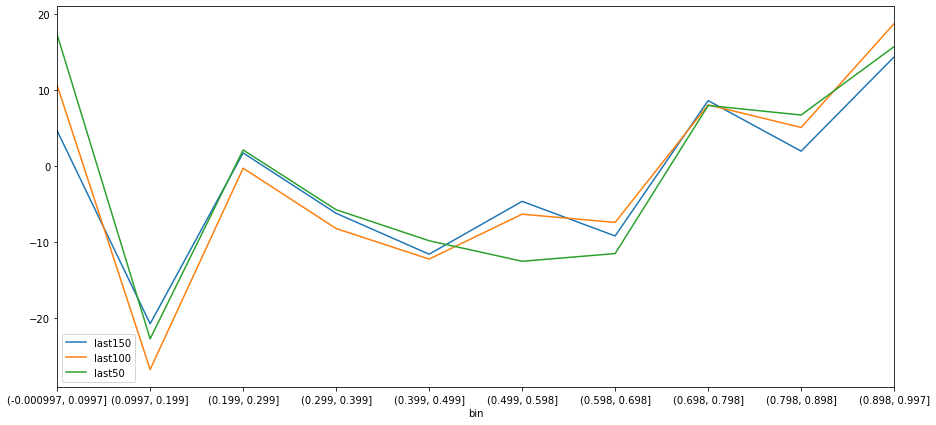

In [1030]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,7))

x = outcome.iloc[150:,:]
y = outcome.iloc[100:,:]
z = outcome.iloc[50:,:]
x1 = x.groupby(['bin'])['Unnamed: 28'].sum().plot(ax=ax)
y1 = y.groupby(['bin'])['Unnamed: 28'].sum().plot(ax=ax)
z1 = z.groupby(['bin'])['Unnamed: 28'].sum().plot(ax=ax)
legend = ['last150','last100','last50']
plt.legend(labels=legend,loc='best')

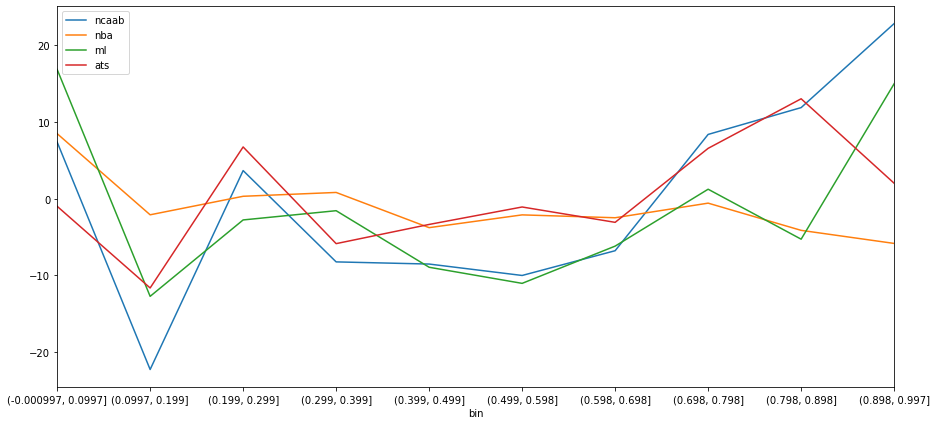

In [1031]:
ncaab = outcome[outcome['Sport']=='ncaab']
nba = outcome[outcome['Sport']=='nba']
ml = outcome[outcome['Type']=='ml']
ats = outcome[outcome['Type']=='ats']
z = 0
fig,ax = plt.subplots(figsize=(15,7))
ncaab.groupby(['bin'])['Unnamed: 28'].sum().plot(ax=ax)
nba.groupby(['bin'])['Unnamed: 28'].sum().plot(ax=ax)
ml.groupby(['bin'])['Unnamed: 28'].sum().plot(ax=ax)
ats.groupby(['bin'])['Unnamed: 28'].sum().plot(ax=ax)
labels2 = ['ncaab','nba','ml','ats']
plt.legend(labels=labels2,loc='best')

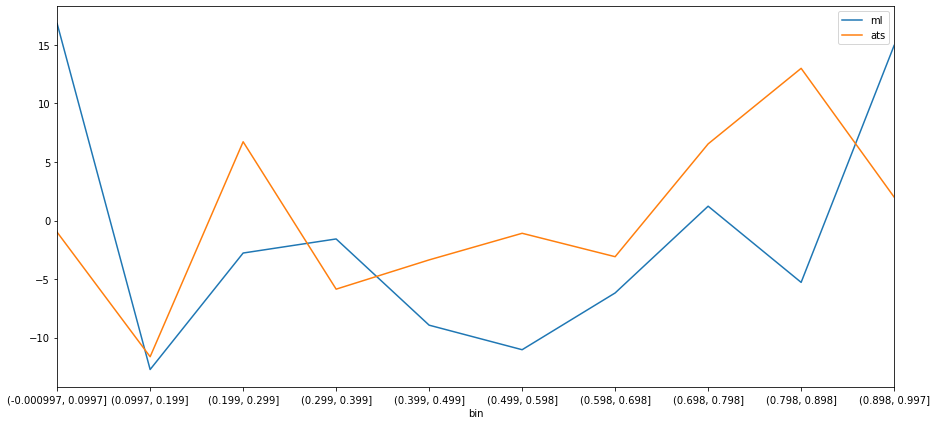

In [1032]:
fig,ax = plt.subplots(figsize=(15,7))

ml.groupby(['bin'])['Unnamed: 28'].sum().plot(ax=ax)
ats.groupby(['bin'])['Unnamed: 28'].sum().plot(ax=ax)
labels2 = ['ml','ats']
plt.legend(labels=labels2,loc='best')

In [1033]:
def bet_plot(tp,sport):
    fig,ax = plt.subplots(figsize=(15,7))
    labels3 = ['bet_type','sport']
    plt.legend(labels=labels3,loc='best')
    return tp.groupby(['bin'])['Unnamed: 28'].sum().plot(ax=ax), sport.groupby(['bin'])['Unnamed: 28'].sum().plot(ax=ax)
    

(<matplotlib.axes._subplots.AxesSubplot at 0x1cfbb890548>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cfbb890548>)

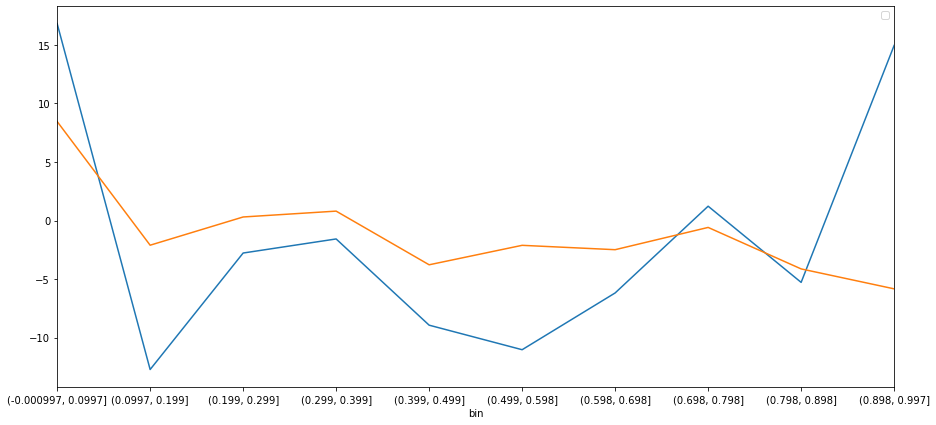

In [1034]:
bet_plot(ml,nba)

In [460]:
outcome = pd.read_excel(r'C:\Users\tdufrene\PersonalPandas\Personal Projects\bets - new_post.02.01.2020.xlsx')
outcome.groupby(['Sport','win_or_loss'])['outcome'].sum()
Xx = outcome[['Sport','Type','home_or_away','WinOdds','predicted win amount','spread','TotalBuffer',
             'win%','away%','home%','Streak','dir','Loserwin%','Loseraway%','Loserhome%','Loserstreak',
              'loserdirection']]
Yy = outcome[['Outcomeid']]

In [461]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
last_row = 838
XX = Xx.iloc[:last_row,:]
#print(XX)
YY = Yy.iloc[:last_row,:]
pred = Xx.iloc[last_row:,:]
#print(pred)
one = OneHotEncoder(sparse=False)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(ColumnTransformer([('scaling', StandardScaler(), ['WinOdds',
                                                       'predicted win amount','spread',
                                                       'TotalBuffer','win%','away%','home%',
                                                      'Streak','Loserwin%','Loseraway%','Loserhome%',
                                                       'Loserstreak']),
                       ('onehot',OneHotEncoder(sparse=False), ['Sport','Type','home_or_away','dir',
                                                               'loserdirection'])]),
                    RandomForestClassifier(random_state=42))


X_train,X_test,y_train,y_test = train_test_split(XX, YY)


parameters = {
"randomforestclassifier__min_samples_split":[0.2,0.6,.9],
"randomforestclassifier__n_estimators":[10,40,80,100,120],
"randomforestclassifier__min_samples_leaf":[2,4,6,8]}
stratkfold = StratifiedKFold(n_splits=5)
cv = GridSearchCV(pipe, param_grid=parameters, cv=stratkfold, n_jobs=-1)
cv.fit(X_train, y_train.values.ravel())


#scores = cross_val_score(gbrt, X_train_trans, y_train, cv = stratkfold)
print('Train set score: {:.2f}'.format(cv.score(X_train,y_train)))
print('Test set score: {:.2f}'.format(cv.score(X_test,y_test)))
print(cv.best_params_)
print(cv.best_score_)
results = pd.DataFrame(cv.cv_results_)
results[results['rank_test_score']==1]

Train set score: 0.71
Test set score: 0.56
{'randomforestclassifier__min_samples_leaf': 6, 'randomforestclassifier__min_samples_split': 0.2, 'randomforestclassifier__n_estimators': 120}
0.6289808917197452


c:\users\tdufrene\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
34,0.346179,0.04295,0.021541,0.001619,6,0.2,120,{'randomforestclassifier__min_samples_leaf': 6...,0.661417,0.68254,0.6,0.52,0.68,0.628981,0.061948,1


In [247]:
def avg_pred(c=0):
    data = []
    data2 = []
    while c< 20:
        outcome = pd.read_excel(r'C:\Users\tdufrene\PersonalPandas\Personal Projects\bets - new_post.02.01.2020.xlsx')
        Xx = outcome[['Sport','Type','home_or_away','WinOdds','predicted win amount','spread','TotalBuffer',
                      'win%','away%','home%','Streak','dir','Loserwin%','Loseraway%','Loserhome%','Loserstreak',
                      'loserdirection']]
        XX = Xx.iloc[:last_row,:]
        YY = Yy.iloc[:last_row,:]
        pred = Xx.iloc[last_row:,:]

        z = cv.predict_proba(pred)
        data.append(z)
        c+=1
    mat = pd.DataFrame(list(map(np.ravel, data)))
    prop = mat.T
    prop2 = prop.iloc[1::2]
    prop2['avg'] = prop2.mean(axis=1)
    return prop2

avg_prob = avg_pred()
probability = avg_prob.iloc[:,-1]
avg = probability.reset_index().iloc[:,1]
avg_ = avg.to_list()
avg_prob
pred['prob'] = avg_
pred

c:\users\tdufrene\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\tdufrene\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Sport,Type,home_or_away,WinOdds,predicted win amount,spread,TotalBuffer,win%,away%,home%,Streak,dir,Loserwin%,Loseraway%,Loserhome%,Loserstreak,loserdirection,prob
614,ncaab,ml,home,-125,-9.8,-1.0,10.8,0.5484,0.416667,0.666667,5,W,0.6333,0.333333,0.866667,1,L,0.673662
615,ncaab,ml,away,185,5.0,5.0,10.0,0.3333,0.083333,0.600000,1,W,0.5806,0.166667,0.875000,3,L,0.363688
616,ncaab,ml,home,-165,-7.9,-3.5,11.4,0.5172,0.400000,0.642857,1,L,0.6207,0.600000,0.642857,1,W,0.654517
617,ncaab,ml,away,-135,1.6,2.0,3.6,0.7586,0.545455,0.866667,1,W,0.5862,0.222222,0.812500,3,W,0.605599
618,ncaab,ml,home,-235,-10.1,-5.5,15.6,0.6897,0.400000,0.882353,3,W,0.6897,0.545455,0.823529,4,W,0.687766
619,ncaab,ml,home,-230,-3.8,5.5,9.3,0.5517,0.277778,1.000000,4,W,0.5333,0.266667,0.916667,4,W,0.659609
620,ncaab,ml,away,-155,7.6,-3.0,10.6,0.3333,0.250000,0.500000,2,W,0.1667,0.047619,0.444444,4,L,0.520601
621,ncaab,ml,away,115,9.9,2.0,11.9,0.1379,0.076923,0.200000,1,L,0.1000,0.066667,0.142857,1,W,0.359809
622,ncaab,ml,away,-115,5.9,0.0,5.9,0.5000,0.200000,0.846154,2,W,0.5000,0.500000,0.615385,1,L,0.583499
623,ncaab,ml,away,130,0.3,2.0,2.3,0.5625,0.266667,0.785714,1,W,0.4667,0.285714,0.714286,1,W,0.564760


In [248]:
pred.to_excel(r'C:\Users\tdufrene\PersonalPandas\Personal Projects\days\{}-prediction_probab-rf.xlsx'.format(date.today()))

In [462]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
last_row = 838
XX = Xx.iloc[:last_row,:]
#print(XX)
YY = Yy.iloc[:last_row,:]
pred = Xx.iloc[last_row:,:]
#print(pred)
one = OneHotEncoder(sparse=False)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(ColumnTransformer([('scaling', StandardScaler(), ['WinOdds',
                                                       'predicted win amount','spread',
                                                       'TotalBuffer','win%','away%','home%',
                                                      'Streak','Loserwin%','Loseraway%','Loserhome%',
                                                       'Loserstreak']),
                       ('onehot',OneHotEncoder(sparse=False), ['Sport','Type','home_or_away','dir',
                                                               'loserdirection'])]),
                    LogisticRegression())


X_train,X_test,y_train,y_test = train_test_split(XX, YY)


parameters = {
    'logisticregression__C':[0.0001,0.001,0.01,.1,1,10,30,50,100,1000,10000],
    'logisticregression__random_state':[0,2,4,6,7,8,10,42]
}
stratkfold = StratifiedKFold(n_splits=5)
cv = GridSearchCV(pipe, param_grid=parameters, cv=stratkfold, n_jobs=-1)
cv.fit(X_train, y_train.values.ravel())


#scores = cross_val_score(gbrt, X_train_trans, y_train, cv = stratkfold)
print('Train set score: {:.2f}'.format(cv.score(X_train,y_train)))
print('Test set score: {:.2f}'.format(cv.score(X_test,y_test)))
print(cv.best_params_)
print(cv.best_score_)
results = pd.DataFrame(cv.cv_results_)
results[results['rank_test_score']==1]

Train set score: 0.61
Test set score: 0.61
{'logisticregression__C': 0.001, 'logisticregression__random_state': 0}
0.5812101910828026


c:\users\tdufrene\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.019348,0.001353,0.008777,0.001468,0.001,0,"{'logisticregression__C': 0.001, 'logisticregr...",0.614173,0.563492,0.6,0.528,0.6,0.58121,0.031414,1
9,0.019148,0.003645,0.008377,0.001353,0.001,2,"{'logisticregression__C': 0.001, 'logisticregr...",0.614173,0.563492,0.6,0.528,0.6,0.58121,0.031414,1
10,0.022340,0.005375,0.008577,0.000797,0.001,4,"{'logisticregression__C': 0.001, 'logisticregr...",0.614173,0.563492,0.6,0.528,0.6,0.58121,0.031414,1
11,0.021569,0.007243,0.008151,0.001941,0.001,6,"{'logisticregression__C': 0.001, 'logisticregr...",0.614173,0.563492,0.6,0.528,0.6,0.58121,0.031414,1
12,0.020944,0.004636,0.008178,0.001933,0.001,7,"{'logisticregression__C': 0.001, 'logisticregr...",0.614173,0.563492,0.6,0.528,0.6,0.58121,0.031414,1
13,0.026130,0.008112,0.007784,0.001158,0.001,8,"{'logisticregression__C': 0.001, 'logisticregr...",0.614173,0.563492,0.6,0.528,0.6,0.58121,0.031414,1
14,0.019948,0.002746,0.007777,0.002312,0.001,10,"{'logisticregression__C': 0.001, 'logisticregr...",0.614173,0.563492,0.6,0.528,0.6,0.58121,0.031414,1
15,0.017553,0.001491,0.007379,0.000799,0.001,42,"{'logisticregression__C': 0.001, 'logisticregr...",0.614173,0.563492,0.6,0.528,0.6,0.58121,0.031414,1


In [250]:
def avg_pred(c=0):
    data = []
    data2 = []
    while c< 20:
        outcome = pd.read_excel(r'C:\Users\tdufrene\PersonalPandas\Personal Projects\bets - new_post.02.01.2020.xlsx')
        Xx = outcome[['Sport','Type','home_or_away','WinOdds','predicted win amount','spread','TotalBuffer',
                      'win%','away%','home%','Streak','dir','Loserwin%','Loseraway%','Loserhome%','Loserstreak',
                      'loserdirection']]
        XX = Xx.iloc[:last_row,:]
        YY = Yy.iloc[:last_row,:]
        pred = Xx.iloc[last_row:,:]

        z = cv.predict_proba(pred)
        data.append(z)
        c+=1
    mat = pd.DataFrame(list(map(np.ravel, data)))
    prop = mat.T
    prop2 = prop.iloc[1::2]
    prop2['avg'] = prop2.mean(axis=1)
    return prop2

avg_prob = avg_pred()
probability = avg_prob.iloc[:,-1]
avg = probability.reset_index().iloc[:,1]
avg_ = avg.to_list()
pred['prob'] = avg_
pred

c:\users\tdufrene\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\tdufrene\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Sport,Type,home_or_away,WinOdds,predicted win amount,spread,TotalBuffer,win%,away%,home%,Streak,dir,Loserwin%,Loseraway%,Loserhome%,Loserstreak,loserdirection,prob
614,ncaab,ml,home,-125,-9.8,-1.0,10.8,0.5484,0.416667,0.666667,5,W,0.6333,0.333333,0.866667,1,L,0.529932
615,ncaab,ml,away,185,5.0,5.0,10.0,0.3333,0.083333,0.600000,1,W,0.5806,0.166667,0.875000,3,L,0.471364
616,ncaab,ml,home,-165,-7.9,-3.5,11.4,0.5172,0.400000,0.642857,1,L,0.6207,0.600000,0.642857,1,W,0.524539
617,ncaab,ml,away,-135,1.6,2.0,3.6,0.7586,0.545455,0.866667,1,W,0.5862,0.222222,0.812500,3,W,0.532441
618,ncaab,ml,home,-235,-10.1,-5.5,15.6,0.6897,0.400000,0.882353,3,W,0.6897,0.545455,0.823529,4,W,0.548353
619,ncaab,ml,home,-230,-3.8,5.5,9.3,0.5517,0.277778,1.000000,4,W,0.5333,0.266667,0.916667,4,W,0.535097
620,ncaab,ml,away,-155,7.6,-3.0,10.6,0.3333,0.250000,0.500000,2,W,0.1667,0.047619,0.444444,4,L,0.497440
621,ncaab,ml,away,115,9.9,2.0,11.9,0.1379,0.076923,0.200000,1,L,0.1000,0.066667,0.142857,1,W,0.447484
622,ncaab,ml,away,-115,5.9,0.0,5.9,0.5000,0.200000,0.846154,2,W,0.5000,0.500000,0.615385,1,L,0.514408
623,ncaab,ml,away,130,0.3,2.0,2.3,0.5625,0.266667,0.785714,1,W,0.4667,0.285714,0.714286,1,W,0.499393


In [251]:
pred.to_excel(r'C:\Users\tdufrene\PersonalPandas\Personal Projects\days\{}-prediction_probab-logreg.xlsx'.format(date.today()))